### Zac Patel
### Data H195B
### 4/20/20

## Data Presentation Example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

In [2]:
# Utility Functions and Data 

# maps shorthands in sample filenames to "english" translations of what they stand for
fname_shorthand_dict = {
    "s": "stride",
    "f": "filter_count"
}


def parse_sample_filename(fname):
    """
    Parameters:
        fname: string of a sample filename (no file extension)
        
    Returns:
        params: characters in fname 
        vals: values corresponding to those characters
        
    This method is used for decoding the paramter values encoded in the filenames of samples
    >>> parse_sample_filename("a1b2c10")
    >>> (['a', 'b', 'c'], ['1', '2', '10'])
    """
    params = re.findall("[a-zA-Z]{1}", fname)
    
    # translating param shorthand to "English" name
    params = list(map(lambda x: fname_shorthand_dict[x], params))
    
    vals = re.findall("[0-9]+", fname) 
    

    return params, vals


In [3]:
print(fname_shorthand_dict)

{'s': 'stride', 'f': 'filter_count'}


#### Loading Data from json files output by TensorFlow Profiler

In [4]:
# Location of json files containing profile data
data_base_path = "collab_sample_data/"

# storing a dictionary of sample names to sample DataFrames
# will eventually be used to extract meaningful data and create one big DataFrame
sample_dfs = []

# goes through every .json file in the data_base_path directory and turns it into a DataFrame
# these DataFrames are then added into the sample_dfs dict for further processing
for fname in os.listdir(data_base_path):
    # appending the base path to the filename so it can be loaded by pandas
    full_fname = data_base_path + fname
    
    # only read in json
    if full_fname.endswith(".json"):
        json_raw = pd.read_json(
            path_or_buf = full_fname,
            orient = "records"
        )
        
        # TODO: change this script to using functions like map, flatmap, etc.
        
        # extract column names from first row of first col in loaded json
        col_names = [json_raw.cols[0][i]["id"] for i in range(len(json_raw.cols[0]))]
        
        # split the single row loaded from the json into 1 array per row
        rows = [json_raw.rows[0][i]["c"] for i in range(len(json_raw.rows[0]))]
        # transform "rows" (current lists of dicts) into lists of values
        rows = [[row[i]["v"] for i in range(len(row))] for row in rows]
        #print(col_names)
        #print(rows[0])
        
        # now that rows and columns have been extracted, turn them into a 'real' DataFrame
        formatted_df = pd.DataFrame(data=rows, columns=col_names)
        
        # add the values for experimental parameters (e.g. strides, ) as new columns to our dataframe
        params, vals = parse_sample_filename(re.sub(".json", "", fname))
        
        #print(params)
        formatted_df[params] = pd.DataFrame([vals], index = formatted_df.index)
        #print(formatted_df.head())
        
        # adding our new DataFrame to the sample_dfs dict with key = fname
        # (sub to cut off the '.json' from the filename)
        sample_dfs.append(formatted_df)

In [5]:
# printing an example of what one of the sample dataframes should look like
#sample_dfs[0].head()

In [6]:
# Combining sample D
concat_df = pd.concat(sample_dfs)

### Exploring the Data

In [7]:
# printing the schema of our combined DataFrame
concat_df.head()

,rank,kernel_name,registers_per_thread,shmem_bytes,block_dim,grid_dim,is_op_tensor_core_eligible,is_kernel_using_tensor_core,op_name,occurrences,total_duration_us,avg_duration_us,min_duration_us,max_duration_us,stride,filter_count
0,1,maxwell_scudnn_128x32_relu_interior_nn,0,0,"1,1,1","1,1,1",True,False,sequential_107/conv2d_109/Conv2D,1,10.079,10.079,10.079,10.079,5,1
1,2,maxwell_scudnn_128x32_stridedB_splitK_interior_nn,0,0,"1,1,1","1,1,1",True,False,gradient_tape/sequential_107/conv2d_109/Conv2D...,1,9.824,9.824,9.824,9.824,5,1
2,3,"void gemv2N_kernel<int, int, float, float, flo...",0,0,"1,1,1","1,1,1",False,False,gradient_tape/sequential_107/dense_106/Tensord...,1,4.864,4.864,4.864,4.864,5,1
3,4,void tensorflow::BiasGradNCHW_SharedAtomics<fl...,0,0,"1,1,1","1,1,1",False,False,gradient_tape/sequential_107/conv2d_109/BiasAd...,1,4.576,4.576,4.576,4.576,5,1
4,5,void tensorflow::BiasGradNCHW_SharedAtomics<fl...,0,0,"1,1,1","1,1,1",False,False,gradient_tape/sequential_107/dense_106/BiasAdd...,1,4.512,4.512,4.512,4.512,5,1


In [8]:
print("DataFrame Shape: ",  concat_df.shape)
print("Columns: ", concat_df.columns)

DataFrame Shape:  (428, 16)
Columns:  Index(['rank', 'kernel_name', 'registers_per_thread', 'shmem_bytes',
       'block_dim', 'grid_dim', 'is_op_tensor_core_eligible',
       'is_kernel_using_tensor_core', 'op_name', 'occurrences',
       'total_duration_us', 'avg_duration_us', 'min_duration_us',
       'max_duration_us', 'stride', 'filter_count'],
      dtype='object')


In [9]:
# Filtering out some of the calls less useful to our visualization
filtered_cols = concat_df[["kernel_name", "op_name", "total_duration_us", "stride", "filter_count"]]

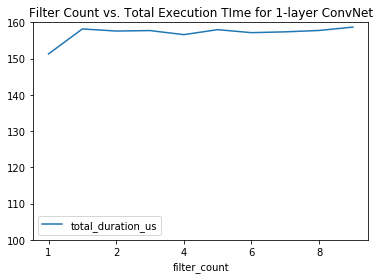

In [10]:
total_exec_time = filtered_cols.groupby(by=["filter_count"]).sum().sort_index()
#print(total_exec_time)

# configuring a plot of the total execution time by filter size
total_exec_time.plot()

plt.title("Filter Count vs. Total Execution TIme for 1-layer ConvNet")
plt.ylim(100, 160)

plt.show()

### Filtering out information about kernels other than Conv2D

In [11]:

conv2D_kernel_info = filtered_cols[filtered_cols["op_name"].str.endswith("Conv2D")]

### Looking at Different Convolution Parameters

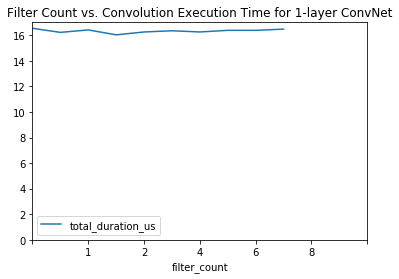

In [12]:
conv2D_kernel_info = conv2D_kernel_info.groupby(by=["filter_count"]).sum().sort_index()


conv2D_kernel_info.plot()
plt.title("Filter Count vs. Convolution Execution Time for 1-layer ConvNet")
plt.ylim(0, 17)
plt.xlim(0, 12)
plt.show()